## Import

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
import re
import os
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from collections import Counter
import cv2

In [ ]:
from konlpy.tag import Okt

## 블라인드 크롤링

In [ ]:
url = 'https://www.teamblind.com/kr/company/NAVER/reviews?page=1'
resp = requests.get(url)
resp

<Response [200]>

In [ ]:
soup = BeautifulSoup(resp.content, 'lxml')
soup

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="user-scalable=no, initial-scale=1, width=device-width, minimal-ui, maximum-scale=1" data-hid="viewport" name="viewport"/>
<meta content="ie=edge" http-equiv="X-UA-Compatible"/>
<title>Your Anonymous Workplace Community - Blind</title>
<link data-n-head="true" href="/favicon.ico" rel="icon" type="image/x-icon"/>
<link href="https://s3-us-west-2.amazonaws.com/www.teamblind.com/error-pages/static-blockpage-last/css/etc.min.css" rel="stylesheet" type="text/css"/>
<script>
        (function () {
            var isKr = String(window.location.pathname).toLowerCase() === '/kr';
            var emailAddress = (isKr ? 'support' : 'blindapp') + '@teamblind.com';
            window.addEventListener('DOMContentLoaded', function () {
                var mailAnchor = document.querySelector('a.email');
                mailAnchor.innerHTML = emailAddress;
                mailAnchor.href = 'mailto:' + emailAddress;
          

In [ ]:
headers = {
    'cookie':'ezosuibasgeneris-1=09401bc4-90c6-462c-4ec1-6fb8046b1bc2; _pbjs_userid_consent_data=3524755945110770; _sharedid=98a1bab7-592f-4e81-8b4b-5d9dcb273c6f; _aimtellSubscriberID=4c69cad5-71f6-13df-dbfb-566116541a65; __gads=ID=81efe6984cf84a4b:T=1667206162:S=ALNI_MZyKDamgSIdoI_8envi8yy5PrSQiQ; _cc_id=b5efb25bc55fb19c51648c4e8eeac406; _gcl_au=1.1.1460413566.1667361618; _rdt_uuid=1667361617875.21f447b5-4f08-4de5-b91f-2e5e1373dd9f; _ga_T1BZFL8Q0J=GS1.1.1667361617.1.0.1667361617.0.0.0; _fbp=fb.1.1667361617922.1017294750; sa-user-id=s%3A0-9f2c8cc5-1790-4fb2-4539-b04a5d0cfc63.88YOl5VIfu%2BVWuWm6gZDVh246BuJ2x5jONKMvUkZtf0; sa-user-id-v2=s%3ASP53omZ6TAdu7TQjgDo5zwHXdkQ.Y0Nn56ICuwyxRRG5oCsgmqosw5QUOongRMtrJu1hCLc; bl_session=eyJub3dJbk1pbnV0ZXMiOjI3Nzg5MzYwLCJwdWJLZXkiOiItLS0tLUJFR0lOIFBVQkxJQyBLRVktLS0tLVxuTUlJQklqQU5CZ2txaGtpRzl3MEJBUUVGQUFPQ0FROEFNSUlCQ2dLQ0FRRUExaFZUeVhRWThDSWNOMGRpYXVWYlxuK2VtaDgyb1ZnOTdidkZPdlRteFpYeDkrNVlwOTdlYmlKNW12V0tueVIraU9FKytoM2U5amZBdVU2UjZVaksrSlxudGRQZjJBM2pNNWNXaXJWcFlSa3ZoeURpV3E5bkoyUFl1cTFUVDJUUjJFSGxpaEFDNEdyWUh2dldBU29CZnBUalxuRjVYcUNaL1A5NU9EYzRuU1lRcGFOekV1dFdPS3RsS1N0cDVXLzBEREg0RDB4eFlpQW9wZ0dTV1c5MURUS0FwV1xuSGtBWDFIZ1Uvcm92N3FLOFNOUk1Ud1BISUdhSXh3Z0JUcUZUS3BNMGNpUjVBejZ1b3JVdDh5T0FYb0JiM20zRlxuQ0tOR3V4ak85TlJqVDVwNmhocThGYVM3YmdlbllqclFXQ1hsMG9xM3FmMXFMai9HVmJCOVlQUy9DOHpZRHRBcVxuendJREFRQUJcbi0tLS0tRU5EIFBVQkxJQyBLRVktLS0tLVxuIiwia2V5IjoiQVVEQkhmeEYiLCJ6bCI6IkRDWFZjZ1dJM2hLZEVEU3dYVXMySng4clZ5UGcvUzRiNndWK3lIaHUxQmVvbkNuMkZBc09ZdW5YdEoxRUYvQjQ1K3RVREx0MjNmdjhUQ1YxUFJNdFZza0ozc3dqQldsTHQwOUZ6WWJmU0dRaklqelFGU2JjdythakMzWVQ2elJnTzE1aVVXOTh0UjFZRTBkbkdjNXozay9YZkZubTYwc3IyVG1ZVTBaME5yenh4dXowL0d5MzEvcm1VNnhrOURTUVFjVFpnRkYvUUdKOUxXd25pRFZKRTdheU4wRmJXck9MTlhMM253cGJKaXhvVlR4RU5KbVFKT2ZFTFhBSndVV3VZKzFHUjZZbVdnM2J2OWdTNjVvUFNoTGttMDZMTzdteXI3dHBMOHMwK2VrSU1LSW4zbSsrOGUzSXp3ekxCTFlDcDcwVmNSdmFIa3U3cEtDUXhyMEgrZz09In0=; bl_session.sig=7mAqyzbuJcfxFn7d7idOZOHGWQ0; _ga=GA1.2.1970929383.1667206163; panoramaId_expiry=1668697255143; panoramaId=d481e8dba7d27d8c95de2b2a20bc16d53938fe3549c90257160ec2e51763a7e3; _gid=GA1.2.1215603844.1668246543; ezepvv=0; __gpi=UID=00000b71ef0d2613:T=1667206162:RT=1668246544:S=ALNI_MZqRoImR_SJxdCqsXlo9mEQ1kEoSw; _gat=1; ezoadgid_339384=-1; ezoref_339384=google.com; ezoab_339384=mod66-c; ezovid_339384=897290215; lp_339384=https://www.teamblind.com/kr/; ezovuuidtime_339384=1668264957; ezovuuid_339384=2b753279-beab-477d-5a08-8b3816db7031; active_template::339384=pub_site.1668264957; ezopvc_339384=1; ezux_lpl_339384=1668264957564|d9966100-dfe5-4f6e-45c4-0cc5cc41270e|true; ezouspvv=0; ezouspva=0; aasd=1|1668264958135; __aaxsc=2; _gat_company=1; cto_bidid=7xqjgV8lMkZrVU96VGRXRGtJSWxac3NvWEFwbE96WGtnTlAlMkJ3d3NWbEs4UHNVcDN3UCUyRjhTa2klMkJ1eDN1MndUSkklMkZjZ2pFV01qb1YzdWVlVDQ1SnRhWVptUDdoSHlxRnVSZVNxOEdPZlFTblZqNEclMkJIYyUzRA; sessionkr=eyJub3dJbk1pbnV0ZXMiOjI3ODA0NDE2LCJwdWJLZXkiOiItLS0tLUJFR0lOIFBVQkxJQyBLRVktLS0tLVxuTUlJQklqQU5CZ2txaGtpRzl3MEJBUUVGQUFPQ0FROEFNSUlCQ2dLQ0FRRUEzaFQyMHk0cnoxWkEwV01RaElMQVxubHdJM2l3Mml0Z0V6eTkzc2kyU2xDOUhYWlE0MlZ4N0RYVkp0QUNid3BodG9LK2k2YTUxT0draTRVMEhCcmhabFxuNnBPTkJQSUJpU2N3RHY4TkhXZThEcFB4dUlYQUhuZ2s5Uk4ydVhZVXFZY0dtQWdPemlkdXdnc042MjNpZjJCb1xuTGp0K0F6VWpiSlNZNWprWStUcWJvbTFsN2U2SDl1ZGk2QlA3ZjBhR3JIUW83NU4vR29tei9KRlNIMDJjRWtvNVxuSlRqMWZ0WkJLSzAvR2UxOFN6VFhERmpVdkg1OHhsRkJUSndQbmJRM1BoNnA2YUNVclpiVmxTTjFURW05K1ZnUVxuWFoyMGpDWCttYUlxK0tKVFB6ZW8yRjlMNmMrRXg0dkNkS24wb1B3QUdFY1M2N0dObnJwYXhZL3hETFE3YW9DNlxuSndJREFRQUJcbi0tLS0tRU5EIFBVQkxJQyBLRVktLS0tLVxuIiwia2V5IjoidHhuUnJNakciLCJ6bCI6IjNIaitRdXFHYmJDYWlSU254bU4yRkREZ2ZQOFNxKzVUMmd5WVc0akhSZXRRVXpsdVRldCs3NHRUMUlKOGVGbEZGVWJXQ1YzbGthS21tTHdLY2lsaklxOWdtTkU0dG0zR0lZa1MvQXB0N01xVVZMU1ZTQlB2MEpNTGtRWEF1dm5BTzB3aUh4SnNwdWREZ2JVR0JGcHVHcFJreWh2NEUyVktqM3VtYm9zWGtvamo0OFB3NGpOSW5QekhMb3FzY2gyOXdzWDVsVE5LczhIZW9oZFBBeFlGZVhPZHdTY2JaMG1QZnh1aC80RzFET2RVUHExeDY3cWpVNHFKR2haZ3I1OHFsY3U0bWpJUU1UNmdHdUVwWWRMdVdlMFViaFNBM0Z0QURyN3FSSnkreXFNOEVacm5kdmY5bmhYVlYrdWV4OHNaT3pYcVp6b096a0ZLMVE5V09YVC9hQT09IiwiYXV0aCI6eyJlbmNfdG9rZW4iOiJMNzM3NjM2NCIsImVuY193ZWJfc2Vzc2lvbiI6IjFTc1JtZzN0Q1NCUE1IaWg0N2lmSEdCeXA2UFpxQWowbUFwcUpqTkRGanRmWUZIVUVKIiwibWVtYmVyX2luZm8iOnsiY29tcGFueV9pZCI6ODcyNywiY29tcGFueV9uYW1lIjoiS0Lspp3qtowiLCJjb21wYW55X3JlYWxfbmFtZSI6IktC7Kad6raMIiwibmlja25hbWUiOiJKWnU3OHojOCIsImx2IjpudWxsLCJwb2ludCI6NTk2LCJwcm9maWxlIjp7fX19LCJhdXRoTG9naW5DaGVjayI6NzcyMzR9; sessionkr.sig=efbPdvtuFPpetIoOERgRhxlNgto; wcs_bt=2655882ffc43a4:1668264974; cto_bundle=DCTpAV96cmlOaDJZNUh5c0tIUTlkazBDVTRFc3c5aWQzT2hDcEt2dTY1bWF5YkxXV3VMYVB3WTNpY1VPRlFjRjIxY0RXalJyV3FJJTJGTDgwTGl5QUh6aFZZVkhxWWNLNUJ6U0wzYm9Wc2xjdVN3dHRGSnRRQmxhY2ZKbVZDV01VdVVLZEdXN0h1NVR6YnpWVUg5WXJjQyUyQkEyaWFBJTNEJTNE; ezux_et_339384=6; ezux_tos_339384=29; ezux_ifep_339384=true',
    'referer':'https://www.teamblind.com/kr/company/NAVER/reviews',
    'user-agent':'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Mobile Safari/537.36'
    }

In [ ]:
naver = {'tit_tag':[], 'pros_tag':[], 'cons_tag':[]} 
카카오 = {'tit_tag':[], 'pros_tag':[], 'cons_tag':[]}
라인플러스= {'tit_tag':[], 'pros_tag':[], 'cons_tag':[]}
coupang= {'tit_tag':[], 'pros_tag':[], 'cons_tag':[]}
우아한형제들= {'tit_tag':[], 'pros_tag':[],'cons_tag':[]} 

In [ ]:
#naver, 카카오, 라인플러스, coupang, 우아한형제들 = [], [], [], [], []
네카라쿠배 = ['naver','카카오','라인플러스','coupang','우아한형제들']
companies = {'naver' : [naver['tit_tag'], naver['pros_tag'], naver['cons_tag']],
             '카카오' : [카카오['tit_tag'], 카카오['pros_tag'],카카오['cons_tag']],
             '라인플러스' : [라인플러스['tit_tag'], 라인플러스['pros_tag'], 라인플러스['cons_tag']],
             'coupang' : [coupang['tit_tag'], coupang['pros_tag'], coupang['cons_tag']],
             '우아한형제들' : [우아한형제들['tit_tag'], 우아한형제들['pros_tag'], 우아한형제들['cons_tag']] }

In [ ]:
url = 'https://www.teamblind.com/kr/company/NAVER/reviews?page=1'
resp = requests.get(url, headers = headers)
soup = BeautifulSoup(resp.content, 'lxml')

In [ ]:
tit_tags = soup.select('h3.rvtit a')
pros_tags = soup.select('p')

In [ ]:
pros_tags

In [ ]:
import re

In [ ]:
for company in tqdm(네카라쿠배):   # 회사 순환
    url = 'https://www.teamblind.com/kr/company/{}/reviews'.format(company)
    resp = requests.get(url, headers = headers)
    soup = BeautifulSoup(resp.content, 'lxml')
    last_page = int(soup.select('div.paginate a.nav')[1]['href'].split('=')[1])

    for i in range(1,last_page + 1):   # 리뷰 총 페이지
        url = 'https://www.teamblind.com/kr/company/{}/reviews?page={}'.format(company,i)
        resp = requests.get(url, headers = headers)
        soup = BeautifulSoup(resp.content, 'lxml')
        tit_tags = soup.select('h3.rvtit a')
        
        pros_tags = re.findall('장점</strong><span>(.+?)</span></p>', resp.text.replace('<br/>',""))
        cons_tags = re.findall('단점</strong><span>(.+?)</span></p>', resp.text.replace('<br/>',""))
        #print(pros_tags)
        for tit_tag, pros_tag, cons_tag in zip(tit_tags, pros_tags, cons_tags):
            companies[company][0].append(tit_tag.text)
            companies[company][1].append(pros_tag)
            companies[company][2].append(cons_tag)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(companies)
df

,naver,카카오,라인플러스,coupang,우아한형제들
0,"[“동료들은 좋다 그러나..”, “일한만큼 보상이 주어지는 회사”, “만족할 만한 ...","[“실망스러운 회사”, “매번 정신없이 와다다다다 하는 회사”, “재택 최고”, “...","[“워라벨이 보장되는 회사”, “워라벨 괜찮음 그러나 부바부 경영이 산으로 가는 경...","[“본인이 더 노력한다면 얼마든지 성장의 기회가 열려있는 회사 feat 워라밸”, ...","[“장점이 많은 회사”, “좋은 문화와 동료가 강점인 회사”, “주니어 다니기 좋은..."
1,[재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 ...,[자율 근무제가 장점이었는데 사라짐업무량이 많지 않은 편이고 카무원으로 다니기 좋음...,"[확실한 장점은 풀타임 리모트가 가능한 점이거 빼고는 잘 모르겠다, 장점: 워라벨/...",[조직마다 다르겠지만 분석팀 내 분위기는 서로 의지하고 도움을 줄 수 있는 분위기에...,[월요일 1시출근 나머지 요일 30분 일찍 퇴근해서 주35시간1분만 넘어도 칼같이 ...
2,[까라면 까는 문화일정은 스펙검토 없이 위에서 찍어내린대로 고여기 아니면 니가 갈데...,[영어 이름을 쓰지만 수직적인 분위기꼰대 아저씨들이 많고 회사에 앞으로의 비전이 없...,[특정 조직만 그런전지 모르겠지만 사내 문화가 굉장히 보수적이고 의견 반영이 어려운...,[다만 탑다운으로 업무가 떨어질 때가 있는데 이 때 왜 그러는지에 대한 내용은 잘 ...,[업무적으로 얄짤없음 당연한거지만 그만큼 스트레스도..업무량도 많은편커뮤니케이션이나...


In [ ]:
df.to_csv('blind_init.csv', index = False)

In [ ]:
company1, company2, pros, cons, pros_label, cons_label = [], [], [], [], [], []

In [ ]:
label = {
    'company1': [],
    'pros':[],
    'pros_label':[],
    'company2': [],
    'cons':[],
    'cons_label':[]
 }
 
# 회사별로 장단점 리스트에서 빼기
# 장점은 1, 단점은 0 입력하기 
# 회사명 넣어주기

for i in tqdm(range(len(df['naver'][0]))):
    label['pros'].append(df['naver'][1][i])
    label['pros_label'].append('1')
    label['company1'].append('naver')

for i in tqdm(range(len(df['naver'][0]))):
    label['cons'].append(df['naver'][2][i])
    label['cons_label'].append('0')
    label['company2'].append('naver')
    
for i in tqdm(range(len(df['카카오'][0]))):
    label['pros'].append(df['카카오'][1][i])
    label['pros_label'].append('1')
    label['company1'].append('kakao')

for i in tqdm(range(len(df['카카오'][0]))):
    label['cons'].append(df['카카오'][2][i])
    label['cons_label'].append('0')
    label['company2'].append('kakao')

for i in tqdm(range(len(df['라인플러스'][0]))):
    label['pros'].append(df['라인플러스'][1][i])
    label['pros_label'].append('1')
    label['company1'].append('line')

for i in tqdm(range(len(df['라인플러스'][0]))):
    label['cons'].append(df['라인플러스'][2][i])
    label['cons_label'].append('0')
    label['company2'].append('line')
                
for i in tqdm(range(len(df['coupang'][0]))):
    label['pros'].append(df['coupang'][1][i])
    label['pros_label'].append('1')
    label['company1'].append('coupang')

for i in tqdm(range(len(df['coupang'][0]))):
    label['cons'].append(df['coupang'][2][i])
    label['cons_label'].append('0')
    label['company2'].append('coupang')

for i in tqdm(range(len(df['우아한형제들'][0]))):
    label['pros'].append(df['우아한형제들'][1][i])
    label['pros_label'].append('1')
    label['company1'].append('baemin')

for i in tqdm(range(len(df['우아한형제들'][0]))):
    label['cons'].append(df['우아한형제들'][2][i])
    label['cons_label'].append('0')
    label['company2'].append('baemin')


  0%|          | 0/4415 [00:00<?, ?it/s]

  0%|          | 0/4415 [00:00<?, ?it/s]

  0%|          | 0/1780 [00:00<?, ?it/s]

  0%|          | 0/1780 [00:00<?, ?it/s]

  0%|          | 0/1064 [00:00<?, ?it/s]

  0%|          | 0/1064 [00:00<?, ?it/s]

  0%|          | 0/3317 [00:00<?, ?it/s]

  0%|          | 0/3317 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

In [ ]:
df1 = pd.DataFrame(label)
df1

,company1,pros,pros_label,company2,cons,cons_label
0,naver,재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋...,1,naver,까라면 까는 문화일정은 스펙검토 없이 위에서 찍어내린대로 고여기 아니면 니가 갈데가...,0
1,naver,가끔 업무가 몰릴때도 확실하게 추가근무 수당으로 보상을 줍니다.훌륭한 동료들에게 많...,1,naver,사내 식당이 별로입니다.주식이 많이 떨어져서 슬픕니다.,0
2,naver,"소소한 복지가 많고, 동료들의 업무 역량이 높은편. 처우도 만족",1,naver,"아무래도 워라벨이 다소 좋지 않으며, 수직적인 의사결정 체계",0
3,naver,재택근무라는 점과 자율성이 크고 개인 역량을 많이 봐준다는 느낌,1,naver,자율성이 있는 만큼 뭔가 매뉴얼을 보기 힘들다... 케바케가 심하다,0
4,naver,- 네임밸류 - 주식보상 등 현금성 복지체계(많진않지만) - 유연한 근무제도,1,naver,- 20년 전 수준의 명절 상여금 - 업무 툴 변화로 인한 히스토리의 부재 - 회...,0
...,...,...,...,...,...,...
11485,baemin,1. 시간적인 복지가 많고 구성원이 잘 누릴수 있게 보장되어 있음 2. 업무적인 압...,1,baemin,1. 금전적 복지가 없음 2. 잦은 조직개편으로 한가지 업무에 대한 전문성을 키우기...,0
11486,baemin,대외적 이미지 좋음 비교적 자유로운 의사소통 그것뿐.... 근무자 연령대 낮음 ...,1,baemin,스타트업 정신이라면서 리스크 검토 안하고 업무 추진함. 에자일이라면서 어제 결정했던...,0
11487,baemin,"회사에서 직원들을 한 명, 한 명 진심으로 케어하고 있다는 생각이 들고 사내 분위기...",1,baemin,개발자에 비해서 다른 직군에 대한 지원이 부족하고 체계가 아직 미흡한 부분이 있음.,0
11488,baemin,"직원들을 생각해서 마련해둔 복지가 많고, 꼰대 리더들이 없음, 대한민국에서 보기 힘...",1,baemin,업무 강도가 다소 쎄다고 느낄 수 있으며 일을 못하는 사람이라면 적응하기 힘들듯.,0


In [ ]:
df_pros = df1[['company1', 'pros','pros_label']]
df_pros.columns = ['company', 'review', 'label']
df_pros

,company,review,label
0,naver,재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋...,1
1,naver,가끔 업무가 몰릴때도 확실하게 추가근무 수당으로 보상을 줍니다.훌륭한 동료들에게 많...,1
2,naver,"소소한 복지가 많고, 동료들의 업무 역량이 높은편. 처우도 만족",1
3,naver,재택근무라는 점과 자율성이 크고 개인 역량을 많이 봐준다는 느낌,1
4,naver,- 네임밸류 - 주식보상 등 현금성 복지체계(많진않지만) - 유연한 근무제도,1
...,...,...,...
11485,baemin,1. 시간적인 복지가 많고 구성원이 잘 누릴수 있게 보장되어 있음 2. 업무적인 압...,1
11486,baemin,대외적 이미지 좋음 비교적 자유로운 의사소통 그것뿐.... 근무자 연령대 낮음 ...,1
11487,baemin,"회사에서 직원들을 한 명, 한 명 진심으로 케어하고 있다는 생각이 들고 사내 분위기...",1
11488,baemin,"직원들을 생각해서 마련해둔 복지가 많고, 꼰대 리더들이 없음, 대한민국에서 보기 힘...",1


In [ ]:
df_cons = df1[['company2', 'cons','cons_label']]
df_cons.columns = ['company', 'review', 'label']
df_cons

,company,review,label
0,naver,까라면 까는 문화일정은 스펙검토 없이 위에서 찍어내린대로 고여기 아니면 니가 갈데가...,0
1,naver,사내 식당이 별로입니다.주식이 많이 떨어져서 슬픕니다.,0
2,naver,"아무래도 워라벨이 다소 좋지 않으며, 수직적인 의사결정 체계",0
3,naver,자율성이 있는 만큼 뭔가 매뉴얼을 보기 힘들다... 케바케가 심하다,0
4,naver,- 20년 전 수준의 명절 상여금 - 업무 툴 변화로 인한 히스토리의 부재 - 회...,0
...,...,...,...
11485,baemin,1. 금전적 복지가 없음 2. 잦은 조직개편으로 한가지 업무에 대한 전문성을 키우기...,0
11486,baemin,스타트업 정신이라면서 리스크 검토 안하고 업무 추진함. 에자일이라면서 어제 결정했던...,0
11487,baemin,개발자에 비해서 다른 직군에 대한 지원이 부족하고 체계가 아직 미흡한 부분이 있음.,0
11488,baemin,업무 강도가 다소 쎄다고 느낄 수 있으며 일을 못하는 사람이라면 적응하기 힘들듯.,0


In [ ]:
blind = pd.concat([df_pros, df_cons], ignore_index=True, axis = 0)
blind

,company,review,label
0,naver,재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋...,1
1,naver,가끔 업무가 몰릴때도 확실하게 추가근무 수당으로 보상을 줍니다.훌륭한 동료들에게 많...,1
2,naver,"소소한 복지가 많고, 동료들의 업무 역량이 높은편. 처우도 만족",1
3,naver,재택근무라는 점과 자율성이 크고 개인 역량을 많이 봐준다는 느낌,1
4,naver,- 네임밸류 - 주식보상 등 현금성 복지체계(많진않지만) - 유연한 근무제도,1
...,...,...,...
22975,baemin,1. 금전적 복지가 없음 2. 잦은 조직개편으로 한가지 업무에 대한 전문성을 키우기...,0
22976,baemin,스타트업 정신이라면서 리스크 검토 안하고 업무 추진함. 에자일이라면서 어제 결정했던...,0
22977,baemin,개발자에 비해서 다른 직군에 대한 지원이 부족하고 체계가 아직 미흡한 부분이 있음.,0
22978,baemin,업무 강도가 다소 쎄다고 느낄 수 있으며 일을 못하는 사람이라면 적응하기 힘들듯.,0


In [ ]:
blind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22980 entries, 0 to 22979
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   company  22980 non-null  object
 1   review   22980 non-null  object
 2   label    22980 non-null  object
dtypes: object(3)
memory usage: 538.7+ KB


In [ ]:
blind.shape

(22980, 3)

## 독립변수(X_train), 종속변수(y_train)로 나누기

In [ ]:
X_train = blind.review
y_train = blind.label

In [ ]:
X_train[0], y_train[0]

('재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋고 자유도가 확보되어 좋음', '1')

## 데이터 전처리 함수 정의

In [ ]:
def preprocessing(review): 
    okt = Okt()
    
    f = open('nsmc_stopwords.txt')
    stop_words = f.read().split()
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 토큰화 + 품사 태깅
    word_review = okt.pos(review_text, stem=True)
    
    # 노이즈 & 불용어 제거
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words and len(token) > 1]
       
    # 명사, 동사, 형용사 추출
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]
    # print(word_review)


    # n-gram : bi-gram
    #n_gram = [' '.join(word_review[i:i+1]) for i in range(len(word_review)-1)]
    # print('n-gram')
    # print(n_gram)

    # 기존 토큰 뭉치 + n-gram
    #word_review += n_gram
    # print('n-gram 토큰 추가된 뭉치')
    # print(word_review)

    return word_review

In [ ]:
X_train = blind[(blind['company'] == 'naver') & (blind['label'] == '1')]

In [ ]:
X_train

,company,review,label
0,naver,재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋...,1
1,naver,가끔 업무가 몰릴때도 확실하게 추가근무 수당으로 보상을 줍니다.훌륭한 동료들에게 많...,1
2,naver,"소소한 복지가 많고, 동료들의 업무 역량이 높은편. 처우도 만족",1
3,naver,재택근무라는 점과 자율성이 크고 개인 역량을 많이 봐준다는 느낌,1
4,naver,- 네임밸류 - 주식보상 등 현금성 복지체계(많진않지만) - 유연한 근무제도,1
...,...,...,...
4410,naver,"개발문화, 개발자 실력 등이 모두 최상위 티어. 네이버 서비스 무료 이용가능하며 수...",1
4411,naver,"모두가 아는 회사, 네이버 다닌다하면 모두들 부러운 눈빛으로 바라봄, 자유로운 사내...",1
4412,naver,연차 자유롭게 쓸 수 있고 개발자라면 누구나 꿈꿀 만큼 개발 환경이 우수하다.,1
4413,naver,휴게 공간이나 회사 시설이 매우 잘되어 있음. 회사 다닐 맛 난다. 자유롭고 편하게...,1


In [ ]:
X_train = X_train[X_train['review'].notnull()]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4415 entries, 0 to 4414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   company  4415 non-null   object
 1   review   4415 non-null   object
 2   label    4415 non-null   object
dtypes: object(3)
memory usage: 138.0+ KB


In [ ]:
words = []

for word in tqdm(X_train['review']):
    words.append(preprocessing(word))

  0%|          | 0/4415 [00:00<?, ?it/s]

In [ ]:
n_pros = []

for x in tqdm(X_train['review']):
    w = preprocessing(x)
    n_pros.extend(w)

n_p_count = Counter(n_pros)

  0%|          | 0/4415 [00:00<?, ?it/s]

In [ ]:
n_p_count

Counter({'재택근무': 157,
         '좋다': 2352,
         '빵빵': 23,
         '다재': 4,
         '협업': 37,
         '해주다': 135,
         '동료': 1044,
         '든든하다': 9,
         '사내': 241,
         '복지': 1344,
         '자유도': 9,
         '확보': 4,
         '되어다': 193,
         '가끔': 9,
         '업무': 580,
         '몰리다': 5,
         '확실하다': 60,
         '추가': 8,
         '근무': 271,
         '수당': 30,
         '보상': 278,
         '줍다': 11,
         '훌륭하다': 164,
         '배우다': 496,
         '있다': 2278,
         '소소하다': 27,
         '많다': 1134,
         '역량': 69,
         '높다': 245,
         '처우': 73,
         '만족': 41,
         '자율성': 48,
         '크다': 179,
         '개인': 166,
         '보다': 123,
         '주다': 147,
         '느낌': 75,
         '임밸류': 216,
         '주식': 13,
         '현금': 15,
         '체계': 65,
         '않다': 321,
         '유연하다': 66,
         '제도': 100,
         '커리어': 285,
         '향상': 93,
         '이다': 174,
         '똑똑하다': 131,
         '부바': 94,
         '이기다': 31,
    

In [ ]:
n_p_count = list(n_p_count.items())
df_n_count = pd.DataFrame(n_p_count, columns = ['토큰화', '갯수'])

In [ ]:
df1 = df_n_count.sort_values(['갯수'], ascending = False)
df1

,토큰화,갯수
1,좋다,2352
24,있다,2278
52,하다,2206
9,복지,1344
26,많다,1134
...,...,...
2496,심리상담,1
2495,상품,1
2494,덕질,1
2493,교환,1


In [ ]:
df1 = df1['토큰화'].map({'라벨': '워라벨'})
df1

1       NaN
24      NaN
52      NaN
9       NaN
26      NaN
       ... 
2496    NaN
2495    NaN
2494    NaN
2493    NaN
2797    NaN
Name: 토큰화, Length: 2798, dtype: object

## 워드클라우드로 텍스트 시각화

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
img = Image.open("원.png")   
img = np.array(img)
img

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

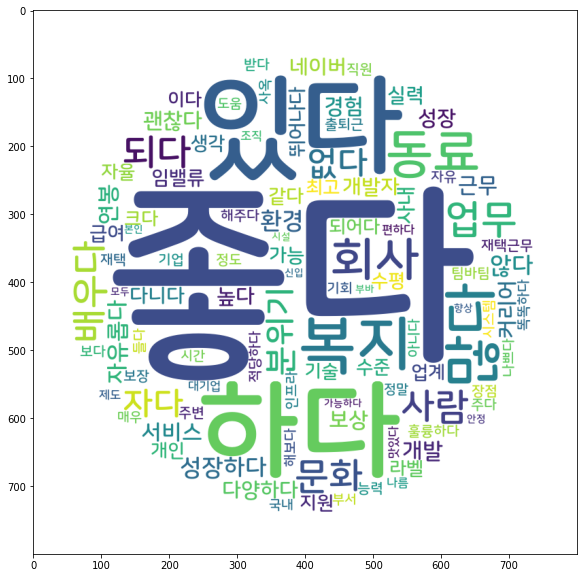

In [ ]:
wc=WordCloud(font_path='NanumSquareRoundOTFB.otf',
             background_color='white', mask = img, width=1000, height=1000, max_words=100, max_font_size=300)

plt.figure(figsize = (20,10))
word = wc.generate_from_frequencies(dict(n_p_count))
# wc.to_file("wc_title.png")
plt.imshow(word)

In [ ]:
def preprocessing(review): 
    okt = Okt()
    
    f = open('nsmc_stopwords.txt')
    stop_words = f.read().split()
    review_text = re.sub("[^가-힣\\s]", "", review)
    word_review = okt.pos(review_text, stem=True)
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words and len(token) > 1]
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]
    n_gram = [' '.join(word_review[i:i+2]) for i in range(len(word_review)-1)]
    word_review = n_gram
    #word_review += n_gram
    # print('n-gram 토큰 추가된 뭉치')
    # print(word_review)

    return word_review

In [ ]:
n_pros2 = []

for x in tqdm(X_train['review']):
    w = preprocessing(x)
    n_pros2.extend(w)

n_p_count2 = Counter(n_pros2)

  0%|          | 0/4415 [00:00<?, ?it/s]

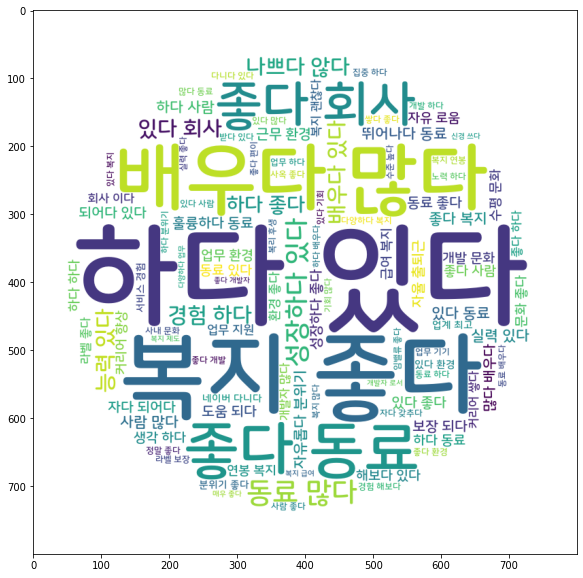

In [ ]:
wc=WordCloud(font_path='NanumSquareRoundOTFB.otf',
             background_color='white', mask = img, width=1000, height=1000, max_words=100, max_font_size=300)

plt.figure(figsize = (20,10))
word = wc.generate_from_frequencies(dict(n_p_count2))
# wc.to_file("wc_title.png")
plt.imshow(word)

In [ ]:
import pickle
from google.colab import drive

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

In [ ]:
df = pd.read_csv('DataBlind.csv')
df

,enter,review,label
0,NAVER,재택근무 좋고 수당빵빵하다재택중에도 열심히 협업해주는 동료들이 든든하다사내 복지 좋...,1
1,NAVER,재택근무라는 점과 자율성이 크고 개인 역량을 많이 봐준다는 느낌,1
2,NAVER,- 네임밸류 - 주식보상 등 현금성 복지체계(많진않지만) - 유연한 근무제도,1
3,NAVER,커리어향상 좋음같이일하는 동료들 똑똑함부바부이긴하지만 우리팀은 야근 많이하는건 지양...,1
4,NAVER,그래도 수평적인 편.역량을 펼칠 기회도 인프라도 (본인이 잘하면) 있는 편.,1
...,...,...,...
19591,BAEMIN,1. 금전적 복지가 없음 2. 잦은 조직개편으로 한가지 업무에 대한 전문성을 키우기...,0
19592,BAEMIN,스타트업 정신이라면서 리스크 검토 안하고 업무 추진함. 에자일이라면서 어제 결정했던...,0
19593,BAEMIN,개발자에 비해서 다른 직군에 대한 지원이 부족하고 체계가 아직 미흡한 부분이 있음.,0
19594,BAEMIN,업무 강도가 다소 쎄다고 느낄 수 있으며 일을 못하는 사람이라면 적응하기 힘들듯.,0


In [ ]:
x_review = df['review']
y_review = df['label']

In [ ]:
print(X_train.shape, y_train.shape)

(19596,) (19596,)


In [ ]:
def preprocessing(review):   
    okt = Okt()    
    
    f = open('nsmc_stopwords.txt')
    stop_words = f.read().split()  
    review_text = re.sub("[^가-힣\\s]", "", review)  
    word_review = okt.pos(review_text, stem=True)   
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words and len(token) > 1]   
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']] 
    n_gram = [' '.join(word_review[i:i+2]) for i in range(len(word_review)-1)]
    print(n_gram)
    word_review += n_gram
    
    return word_review

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# BoW 방식
bow = CountVectorizer(tokenizer=preprocessing, min_df=5, max_df=0.5) 

# X_train_bow = bow.fit(X_train)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_review, y_review, stratify = y_review, shuffle = True, random_state=0)

In [ ]:
# tfidf 방식
tfidf = TfidfVectorizer(tokenizer=preprocessing, max_features=2000, min_df=5, max_df=0.5) 

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.toarray()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['연봉 올려주다', '올려주다 수도', '수도 있다', '있다 세다', '세다 알다', '알다 있다', '있다 리더십', '리더십 부족', '부족 사태', '사태 계속', '계속 악화시키다']
['사내정치 많다', '많다 보이', '보이 어뷰징', '어뷰징 있다', '있다 보임', '보임 알다', '알다 찾다', '찾다 서해', '서해 야하다']
['자율성 남다', '남다 서로', '서로 존중', '존중 가족', '가족 돌보다', '돌보다 휴가', '휴가 부모님', '부모님 실비', '실비 보험']
['시간 정확하다', '정확하다 초과근무', '초과근무 하다', '하다 거의', '거의 없다']
['리프 레쉬', '레쉬 휴가', '휴가 주기', '주기 유급', '유급 휴가', '휴가 휴가', '휴가 야근', '야근 하다', '하다 거의', '거의 없다']
['재택근무 업무', '업무 대해', '대해 하다', '하다 물어보다', '물어보다 사람', '사람 없다', '없다 혼자', '혼자 헤치다', '헤치다 나가야', '나가야 하다', '하다 고스', '고스 나기', '나기 때문', '때문 항상', '항상 하다', '하다 부분', '부분 커리어', '커리어 욕심', '욕심 있다', '있다 사람', '사람 능력', '능력 뽐내다', '뽐내다 있다', '있다 장점', '장점 되다', '되다 무난', '무난 무난', '무난 티나', '티나 않다', '않다 조용하다', '조용하다 이다', '이다 선호', '선호 하다', '하다 사람', '사람 맞다', '맞다 않다', '않다 하나', '하나 튀다', '튀다 좋아하다', '좋아하다 적극', '적극 사람', '사람 자다', '자다 맞다', '맞다 기업', '기업 화일']
['스스로 성장하다', '성장하다 구조', '구조 알다', '알다 해오다', '해오다 알다', '알다 해오다', '해오다 문화']
['급여 복지', '복지 종업', '종업 하위', '하위 복지'

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 모델 정의

In [ ]:
# 분류모델을 담을 리스트 생성 
classifiers = []

# random_state 설정
random_state = 2

# 데이터프레임 생성을 위하여 알고리즘 제목 저장
clf_names = ['Decision Tree','Random Forest', 'AdaBoost', 'Extra Trees', 'Gradient Boost',
             'MLP', 'KNN', 'Support Vector', 'Logistic Regression', 'Linear Discrimination']  # MLP는 딥러닝

# 트리 기반 알고리즘
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))

# 그 외 선형, 신경망 등의 알고리즘
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

## K-fold로 모델 교차검증

In [ ]:
# 레이블인코딩된 데이터로 교차검증을 수행하여 리스트에 저장

kfold = StratifiedKFold(n_splits=10)  # 10번의 교차검증을 시행하겠다. 

cv_results = []
for classifier in classifiers : # 모델 여러개를 묶어놓은 리스트
    cv_results.append(cross_val_score(classifier, X_train_tfidf, y = y_train,
                                      scoring = "accuracy", cv = kfold, n_jobs=4)) # n_jobs는 CPU를 몇개 돌릴지


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pack

In [ ]:
# 교차검증 점수 리스트 출력
cv_results # array 당 classifiers 안에 있는 모델들의 결과 /  검증셋을 바꿔가면서 시행 / n_splits=10 검증결과가 10번 나옴 

[array([0.81088435, 0.79863946, 0.81156463, 0.80544218, 0.82993197,
        0.81156463, 0.78027211, 0.81415929, 0.81143635, 0.78897209]),
 array([0.88911565, 0.86802721, 0.88095238, 0.86666667, 0.89183673,
        0.87959184, 0.86938776, 0.88155208, 0.88359428, 0.86385296]),
 array([0.79931973, 0.80884354, 0.80068027, 0.80816327, 0.83197279,
        0.80680272, 0.78979592, 0.8162015 , 0.80599047, 0.79441797]),
 array([0.89931973, 0.88503401, 0.89795918, 0.88095238, 0.90272109,
        0.89115646, 0.8829932 , 0.90061266, 0.88223281, 0.87950987]),
 array([0.85034014, 0.82380952, 0.8537415 , 0.81972789, 0.85646259,
        0.84353741, 0.82517007, 0.84343091, 0.83798502, 0.81892444]),
 array([0.87755102, 0.87346939, 0.88095238, 0.8707483 , 0.88503401,
        0.87755102, 0.87619048, 0.89244384, 0.88223281, 0.87746767]),
 array([0.83673469, 0.84421769, 0.85510204, 0.83401361, 0.85034014,
        0.82789116, 0.82653061, 0.827774  , 0.81007488, 0.83390061]),
 array([0.91972789, 0.90884354, 0.

In [ ]:
# 첫 번째 모델(Decision Tree Classifier)의 평균 교차검증 점수 출력
cv_results[0].mean()

0.8062867052879694

In [ ]:
# 첫 번째 모델(Decision Tree Classifier)의 교차검증 점수 표준편차 출력
cv_results[0].std()

0.013267234836587198

In [ ]:
# 모델들의 교차검증 점수의 평균과 표준편차를 계산하여 리스트에 저장
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [ ]:
# 데이터프레임으로 변환
results = pd.DataFrame(cv_results, index=clf_names)
results

,0,1,2,3,4,5,6,7,8,9
Decision Tree,0.810884,0.798639,0.811565,0.805442,0.829932,0.811565,0.780272,0.814159,0.811436,0.788972
Random Forest,0.889116,0.868027,0.880952,0.866667,0.891837,0.879592,0.869388,0.881552,0.883594,0.863853
AdaBoost,0.799320,0.808844,0.800680,0.808163,0.831973,0.806803,0.789796,0.816201,0.805990,0.794418
Extra Trees,0.899320,0.885034,0.897959,0.880952,0.902721,0.891156,0.882993,0.900613,0.882233,0.879510
Gradient Boost,0.850340,0.823810,0.853741,0.819728,0.856463,0.843537,0.825170,0.843431,0.837985,0.818924
MLP,0.877551,0.873469,0.880952,0.870748,0.885034,0.877551,0.876190,0.892444,0.882233,0.877468
KNN,0.836735,0.844218,0.855102,0.834014,0.850340,0.827891,0.826531,0.827774,0.810075,0.833901
Support Vector,0.919728,0.908844,0.919728,0.899320,0.912245,0.923129,0.904762,0.918993,0.904016,0.895167
Logistic Regression,0.914286,0.903401,0.917687,0.895238,0.912245,0.919048,0.897959,0.916270,0.904016,0.885636
Linear Discrimination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
